# <center>Детекирование объектов на фотографиях с помощью Faster R-CNN

<center><img src='./img/CV_10_4_1.png'></img></center>

**Задача проекта** - сравнение одно- и двуступенчатых моделей детектирования объектов. В [<b>другом ноутбуке</b>](yolo.ipynb) используется модель *YOLOv8*

Для начала импортируем необходимые библиотеки и фреймворки. Будем использовать предобученные модели из *PyTorch*: *Faster R-CNN model with a ResNet-50-FPN backbone* и *YOLO*

In [35]:
from IPython.display import display, Markdown
import os
import pickle
import time
from tqdm import tqdm
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
# Personal Dataset class
from data_classes.custom_dataset import CustomImageDataset
# DL/ML
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision import io, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection import IntersectionOverUnion, MeanAveragePrecision
from torch.utils.data import WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
# Visualization 
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Plotly configuration
pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
# Project constants
DATA_PATH = './data/VOC2012/'
BATCH_SIZE = 4
RANDOM_STATE = 42
NN_INPUT = (224, 224)
# Check if GPU available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Available accelerator: {DEVICE}\n')
if DEVICE == 'cuda':
    !nvidia-smi

Available accelerator: cuda

Fri Jan 26 21:05:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.40.06              Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   43C    P8             25W /  370W |    3304MiB /  12288MiB |      9%      Default |
|                                         |                        |                  N/A |
+------------------

**Предобработка меток классов:**
1. Воспользуемся парсером *XML*-файлов `ElementTree`, чтобы получить все метки классов и записать их в датафрейм. **Важная особенность:** на одной фотографии может быть изображено несколько объектов, поэтому общее количество всех объектов больше, чем количество файлов

2. Создадим объект класса `LabelEncoder` из библиотеки *sklearn*, обучим (`fit`) на всех классах. Это нам понадобится для кодирования меток в датасете

In [2]:
annotations_list = []
for img_name in os.listdir(DATA_PATH+'JPEGImages'):
    annotation_name = img_name.replace('.jpg', '.xml')
    annotation_root = ET.parse(os.path.join(DATA_PATH+'Annotations', annotation_name)).getroot()
    for child in annotation_root:
        if child.tag == 'object':
            for obj_child in child:
                if obj_child.tag == 'name':
                    class_ = obj_child.text          
                    annotations_list.append(class_)
    
annotations_df = pd.DataFrame(annotations_list, columns=['class'])
label_encoder = LabelEncoder().fit(annotations_df['class'])

In [3]:
with open('./model/label_encoder.pkl', 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)

## <center>Визуальный анализ данных

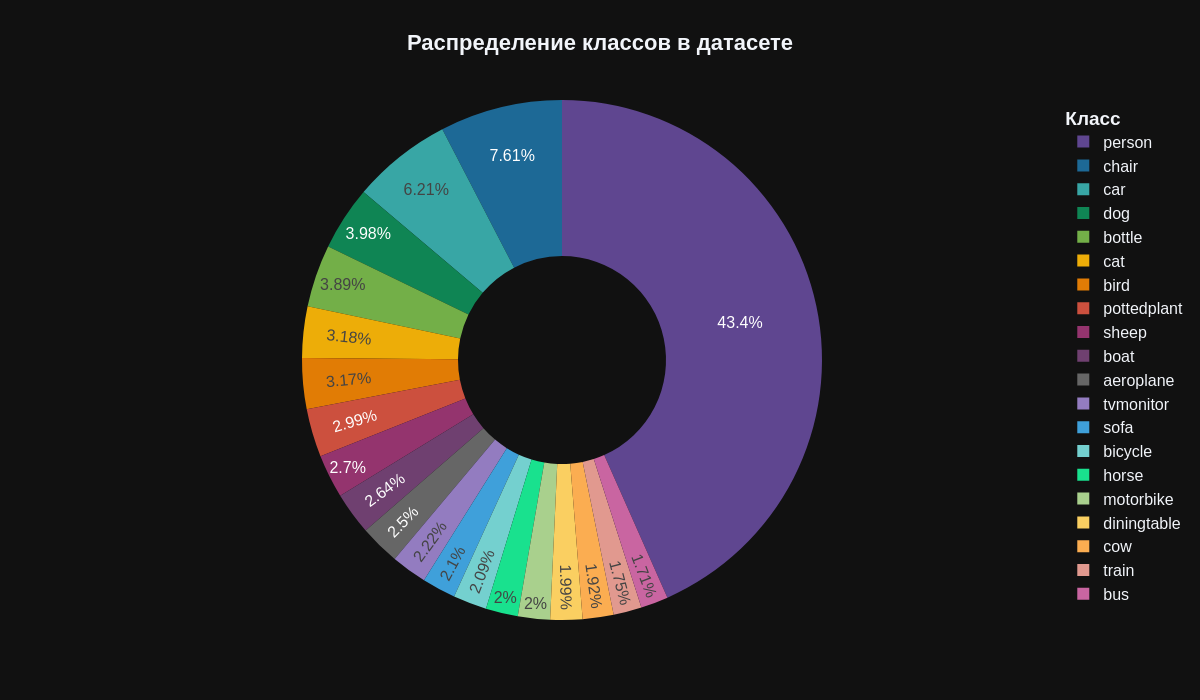

In [3]:
px.pie(
    data_frame=annotations_df, 
    names='class', 
    hole=0.4,
    title='<b>Распределение классов в датасете</b>',
    color_discrete_sequence=px.colors.qualitative.Prism,
    height=700,
    width=1200
).update_layout(
    legend_title='<b>Класс</b>',
    font=dict(size=16),
    title_x=0.5
)

Больше всего имеется наблюдений для человека ($43.4\%$), оставшиеся же классы имеют от $1.7\%$ до $7.6\%$ наблюдений в датасете. Необходимо будет отбалансировать веса классов

## <center>Подготовка датасета

*Faster R-CNN* (во время обучения) принимает на вход батч в следующем виде (на примере `BATCH_SIZE = 1`): изображение + словарь из координат ограничивающей рамки и меток классов для этих рамок. Например:
```py
batch = [
    image,
    dict(
        boxes=[
            [xmin_1, ymin_1, xmax_1, ymax_1], 
            [xmin_2, ymin_2, xmax_2, ymax_2]
        ],
        labels=[
            label_1, 
            label_2
        ]
    )
]
```
Напишем [<b>собственный класс датасета</b>](./data_classes/custom_dataset.py), который может возвращать обучающую, валидационную и тестовую выборки с помощью **стратифицированного** разбиения по классам. Возвращать будем кортеж `(img, dict(boxes, labels))`

Сделаем нормализацию данных для всех выборок. Для нормализации используем среднее и стандартное отклонение, посчитанные для *ImageNet*.

Для обучающей выборки сделаем ресайз до $\{224 \times 224\}$. Изначальные изображения могут быть большого разрешения, из-за чего обучение будет идти дольше.

In [10]:
# ImageNet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Normalize images with ImageNet mean and std
normalize = v2.Normalize(mean=mean, std=std)
# Inversion normalize to visualize 
inv_normalize = v2.Normalize(
   mean = [-m/s for m, s in zip(mean, std)],
   std = [1/s for s in std]
)
# Transforms for train/valid samples with resize
transforms = v2.Compose([
    v2.Resize(NN_INPUT, antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    normalize
])
# Transforms for tests without resize
transforms_test = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    normalize
])
# Split datasets to train, valid and test, move it to GPU if available
train_dataset = CustomImageDataset(
    DATA_PATH,
    label_encoder,
    input_size=NN_INPUT,
    split='train', 
    random_state=RANDOM_STATE,
    transform=transforms,
    device=DEVICE
)
valid_dataset = CustomImageDataset(
    DATA_PATH,
    label_encoder,
    split='valid',
    random_state=RANDOM_STATE,
    transform=transforms_test,
    device=DEVICE
)
test_dataset = CustomImageDataset(
    DATA_PATH,
    label_encoder,
    split='test',
    random_state=RANDOM_STATE,
    transform=transforms_test,
    device=DEVICE
)
# Print results
print(
    f'Количество обучающих примеров: {len(train_dataset)}',
    f'Количество валидационных примеров: {len(valid_dataset)}',
    f'Количество тестовых примеров: {len(test_dataset)}', sep='\n'
)

Количество обучающих примеров: 14070
Количество валидационных примеров: 4772
Количество тестовых примеров: 4833


Посмотрим на распределение классов в каждой выборке. Они должны совпадать, т.к. было использовано стратифицированное разбиение по классам

In [5]:
train_dist = pd.DataFrame(train_dataset.df['label'].value_counts(True).round(2)).T
labels_order = train_dist.columns
valid_dist = pd.DataFrame(valid_dataset.df['label'].value_counts(True).round(2)).T[labels_order]
test_dist = pd.DataFrame(test_dataset.df['label'].value_counts(True).round(2)).T[labels_order]
display(
    Markdown('#### Train sample'),
    train_dist,
    Markdown('#### Valid sample'),
    valid_dist,
    Markdown('#### Test sample'),
    test_dist
)

#### Train sample

label         14    8     6     11    4     7     2     15    16    3     0   \
proportion  0.43  0.08  0.06  0.04  0.04  0.03  0.03  0.03  0.03  0.03  0.02   

label         19    17    1     12    13    10    9     18    5   
proportion  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02

#### Valid sample

label         14    8     6     11    4     7     2     15    16    3     0   \
proportion  0.43  0.08  0.06  0.04  0.04  0.03  0.03  0.03  0.02  0.03  0.03   

label         19    17    1     12    13    10    9     18    5   
proportion  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02

#### Test sample

label         14    8     6     11    4     7     2     15    16    3     0   \
proportion  0.44  0.07  0.06  0.04  0.04  0.03  0.03  0.03  0.03  0.03  0.02   

label         19    17    1     12    13    10    9     18    5   
proportion  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02

Распределение классов практически совпадает, теперь мы можем **посчитать вес для каждого класса**. 

In [6]:
pd.DataFrame(annotations_df['class'].value_counts()).T[label_encoder.classes_]

class  aeroplane  bicycle  bird  boat  bottle  bus   car   cat  chair  cow  \
count       1002      837  1271  1059    1561  685  2492  1277   3056  771   

class  diningtable   dog  horse  motorbike  person  pottedplant  sheep  sofa  \
count          800  1598    803        801   17401         1202   1084   841   

class  train  tvmonitor  
count    704        893

In [7]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=label_encoder.classes_,
    y=annotations_df['class']
)
class_weights

array([2.00289421, 2.39772999, 1.57899292, 1.89508971, 1.28565022,
       2.92978102, 0.80533708, 1.571574  , 0.65670812, 2.60298314,
       2.508625  , 1.25588235, 2.4992528 , 2.50549313, 0.11533245,
       1.66963394, 1.85138376, 2.3863258 , 2.85071023, 2.24736842])

Теперь необходимо правильным образом отбалансировать *train* выборку на основе посчитанных весов. Это можно сделать с помощью класса `WeightedRandomSampler`, который принимает 2 обязательных аргумента: `weights` - **список весов для каждого изображения**, `num_samples` - **количество объектов**.

У каждого изображения (каждый вызов `__getitem__`) есть несколько лейблов, размеченных на этом изображении. Может быть 1 (человек), а может присутствовать сразу 10 разных классов, причем с повторениями.

Воспользуемся следующей логикой для того, чтобы посчитать **вес каждого изображения**: сначала переведем метки классов в их **обратную частоту**, посчитанную ячейкой выше. Например, класс `0 (aeroplane)` превратится в `2.00289421`, и так далее. После этого **усредним все обратные частоты для изображения** и получим **вес самого изображения**. Таким образом, **вес фото будет прямо пропорционален весу всех лейблов на фото**.

In [8]:
weights_for_each_sample = []
for item in train_dataset:
    labels = item[1]['labels'].cpu()
    photo_weight = np.mean([class_weights[label] for label in labels])
    weights_for_each_sample.append(photo_weight)

Напишем даталоадеры для каждой выборки с заранее выбранным `BATCH_SIZE`.  
Для обучающего лоадера добавим `sampler`, который **учитывает веса объектов**, когда выдаёт батч изображений. Во время обучения это поможет чаще обращать внимание на классы, которых в датасете меньше всего.

In [25]:
def collate_fn(batch):
    return tuple(zip(*batch))

sampler = WeightedRandomSampler(weights_for_each_sample, len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

## <center>Визуализация обучающих примеров

Напишем функцию `visualize_batch` - визуализация примеров из батча с соответствующими метками класса и ограничивающими рамками

Визуализируем **обучающую выборку**

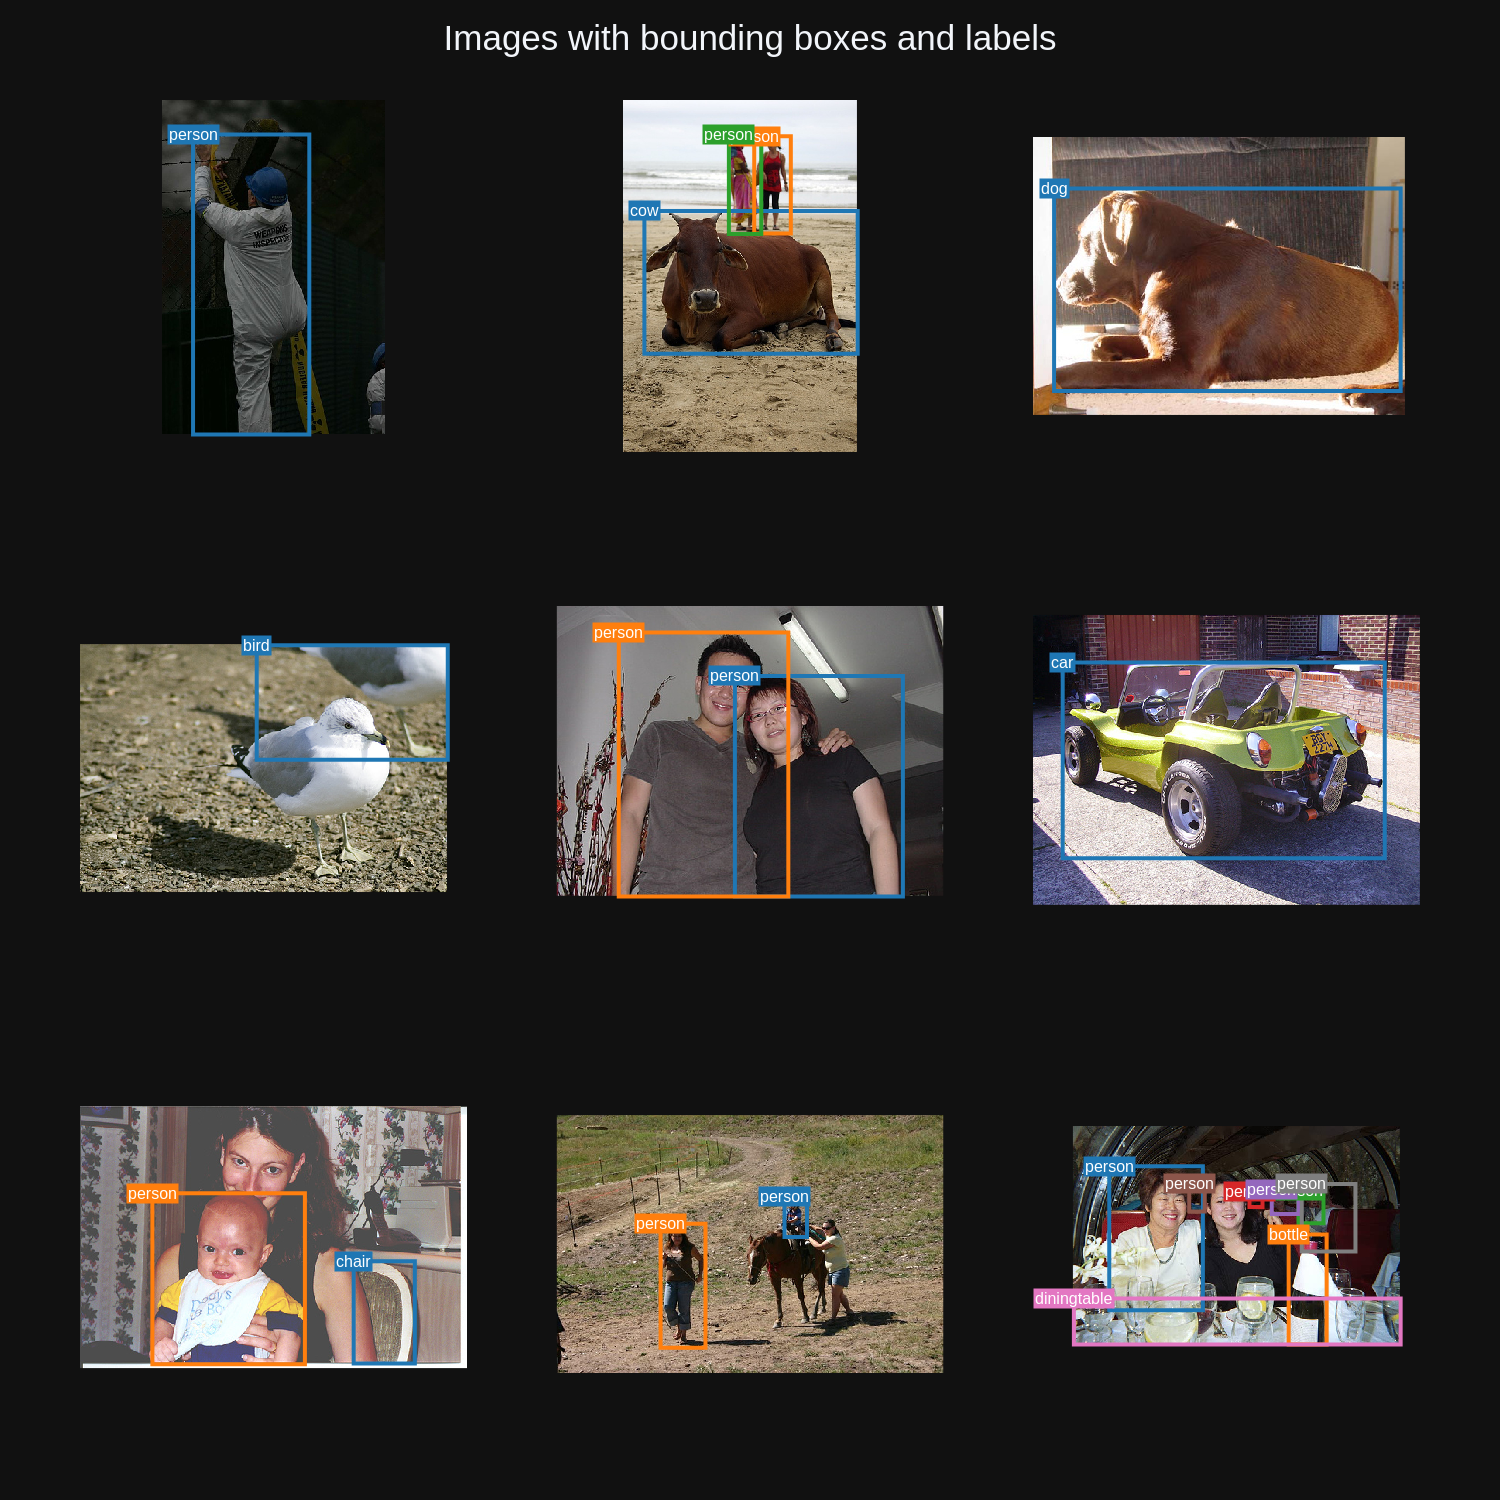

In [10]:
def visualize_batch(dataset:CustomImageDataset, rows=3, cols=3):
    items_df = dataset.df
    batch_name_sample = pd.Series(items_df['name'].unique()).sample(rows*cols)
    batch_sample = items_df[items_df['name'].isin(batch_name_sample)]
    # Grid for plots
    grid = make_subplots(
        rows=rows,
        cols=cols,
    )
    iterators = [
        batch_name_sample.values, # total images to display
        sorted(list(range(1, rows + 1)) * cols), # iteration over rows
        list(range(1, cols + 1)) * rows # iteraion over columns
    ]
    for img_name, row, col in zip(*iterators):
        # Read image and change shape (C, H, W) -> (H, W, C)
        image = io.read_image(os.path.join(DATA_PATH, 'JPEGImages', img_name)).permute(1, 2, 0)
        # Add image to grid
        fig = px.imshow(image)
        grid.add_trace(fig.data[0], row=row, col=col)
        for (_, batch_row), color_cycle in zip(
            batch_sample[batch_sample['name'] == img_name].reset_index(drop=True).iterrows(),
            px.colors.DEFAULT_PLOTLY_COLORS
        ):
            label, xmin, ymin, xmax, ymax = batch_row[['label', 'xmin', 'ymin', 'xmax', 'ymax']].values
            label = label_encoder.inverse_transform([label])[0]
            # Add bbox for image
            grid.add_trace(
                go.Scatter(
                    x=[xmin, xmin, xmax, xmax, xmin],
                    y=[ymin, ymax, ymax, ymin, ymin],
                    mode='lines+text',
                    line=dict(width=4, color=color_cycle),
                ), row=row, col=col
            )
            # Add label for image
            grid.add_annotation(
                x=xmin,
                y=ymin,
                bgcolor=color_cycle,
                text=label,
                font=dict(color='white', size=16),
                align='left',
                showarrow=False,
                row=row,
                col=col
            )
    # Axes and layout configuration
    grid.update_xaxes(
        visible=False
    ).update_yaxes(
        visible=False
    ).update_layout(
        height=1500,
        width=1500,
        title='Images with bounding boxes and labels',
        title_x=0.5,
        font_size=25,
        showlegend=False
    ).show()

visualize_batch(train_dataset)

## <center>Deep Learning</center>
Будем использовать **предобученную** модель *Faster R-CNN model with a ResNet-50-FPN backbone*

В текущей задаче $20$ классов, поэтому **изменим последний слой**, заменив количество выходов классификатора

In [11]:
model = models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT').to(DEVICE)
# Replace last layer for current task
n_classes = len(label_encoder.classes_)
predictor_in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(predictor_in_features, n_classes).to(DEVICE)

Инициализируем **оптимизатор** (стохастический градиентный спуск с *Momentum*). **Темп обучения** возьмем $2 \times 10^{-6}$, т.к. мы не с нуля учим модель, а используем подход *fine-tuning*, так что надо лишь немного подкорректировать веса под текущую задачу

In [12]:
# Low learning rate for fine-tuning with Adam
learning_rate = 2e-6
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
)

**Обучим модель на 3-ех эпохах**. Запишем метрики в словарь `history`. Оценивать качество будем на валидационной выборке, поэтому создадим переменную `best_net_state`, которая поможет вернуться к лучшей эпохе и избежать переобучения.

In [13]:
epochs = 3
history = dict(
    train_loss=[],
    val_loss=[]
)
model.train()
# Callback for best epoch
best_net_state = model.state_dict()
for epoch in range(epochs):
    # Initial state for epoch metrics
    epoch_train_loss = .0
    epoch_val_loss = .0
    tqdm_bar_train = tqdm(train_loader, total=len(train_loader))
    # TRAIN
    for image_batch_train, target_batch_train in tqdm_bar_train:
        optimizer.zero_grad()
        losses_train = model(image_batch_train, target_batch_train)
        loss_train = sum([loss for loss in losses_train.values()])
        loss_train.backward()
        # Update model weights
        optimizer.step()
        epoch_train_loss += loss_train.item()
        tqdm_bar_train.set_description(desc=f"Training Loss: {loss_train.item():.3f}")
    # VALIDATE
    tqdm_bar_val = tqdm(valid_loader, total=len(valid_loader))
    for image_batch_val, target_batch_val in tqdm_bar_val:
        with torch.no_grad():
            losses_val = model(image_batch_val, target_batch_val)
        loss_val = sum([loss for loss in losses_val.values()])
        # Add metrics
        epoch_val_loss += loss_val.item()
        tqdm_bar_val.set_description(desc=f"Validation Loss: {loss_val.item():.3f}")
    avg_epoch_train_loss = epoch_train_loss / len(train_loader)
    avg_epoch_val_loss = epoch_val_loss / len(valid_loader)
    history['train_loss'].append(avg_epoch_train_loss)
    history['val_loss'].append(avg_epoch_val_loss)

    best_epoch = np.argmin(history['val_loss'])
    best_loss = round(history['val_loss'][best_epoch], 3)
    if best_epoch == epoch:
        best_net_state = model.state_dict()
    print(
        f'\n[Epoch {epoch+1}]\n',
        f'train loss: {avg_epoch_train_loss:.3f} | ',
        f'valid loss: {avg_epoch_val_loss:.3f} | ',
        f'best epoch: {best_epoch+1} | ',
        f'best val loss: {best_loss}\n\n',
        '=='*40,
        '\n\n',
        sep='', end=''
    )
model.load_state_dict(best_net_state)
torch.save(model.state_dict(), './model/faster_rcnn_weights.pt')

Validation Loss: 0.161: 100%|██████████| 1193/1193 [04:20<00:00,  4.58it/s]



[Epoch 1]
train loss: 0.442 | valid loss: 0.212 | best epoch: 1 | best val loss: 0.212




Validation Loss: 0.190: 100%|██████████| 1193/1193 [05:06<00:00,  3.89it/s]



[Epoch 2]
train loss: 0.230 | valid loss: 0.191 | best epoch: 2 | best val loss: 0.191




Validation Loss: 0.194: 100%|██████████| 1193/1193 [05:32<00:00,  3.59it/s]


[Epoch 3]
train loss: 0.201 | valid loss: 0.188 | best epoch: 3 | best val loss: 0.188




Визуализация истории *fine-tuning*-а сети

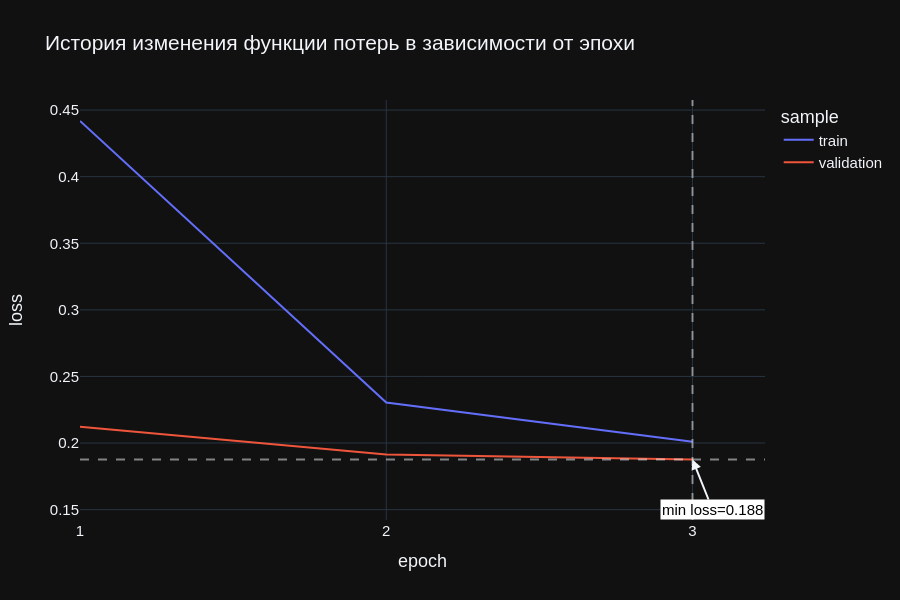

In [14]:
def visualize_history(history):
    # Make DataFrame with metrics for easy visualization
    history_df = pd.DataFrame({
        'loss': list(history['train_loss']) + list(history['val_loss']),
        'sample': ['train']*epochs + ['validation']*epochs,
        'epoch': list(range(1, epochs+1))*2
    })
    # Match correct dtypes
    history_df['loss'] = history_df['loss'].astype(float)
    history_df['sample'] = history_df['sample'].astype(object)
    history_df['epoch'] = history_df['epoch'].astype(int)
    # X and Y coordinates for annotations
    best_epoch_loss = history_df[history_df['sample'] == 'validation']['loss'].argmin() + 1
    min_loss = history_df[history_df['sample'] == 'validation']['loss'].min()
    # Loss plot
    px.line(
        data_frame=history_df,
        x='epoch',
        y='loss',
        color='sample',
        width=900,
        height=600,
        title='История изменения функции потерь в зависимости от эпохи'
    ).update_layout(
        font=dict(size=15),
        xaxis=dict(
            tickmode='linear',
            tick0=1,
            dtick=1
        )
    ).add_vline(
        x=best_epoch_loss,
        line_dash='dash',
        opacity=0.5
    ).add_hline(
        y=min_loss,
        line_dash='dash',
        opacity=0.5
    ).add_annotation(
        x=best_epoch_loss,
        y=min_loss,
        text=f'min loss={min_loss:.3f}',
        arrowwidth=2,
        ax=20,
        arrowhead=2,
        bgcolor='white',
        font_color='black',
        ay=50
    ).show()

visualize_history(history)

## <center>Оценка качества



Напишем функцию для визуализации предсказаний сети. По-умолчанию сделаем порог для предсказанных классов `threshold=0.5`

In [88]:
def visualize_predictions(imgs_batch:tuple, predictions_batch:tuple, threshold=0.5):
    rows = cols = int(np.sqrt(len(imgs_batch)))
    grid = make_subplots(
        rows=rows,
        cols=cols
    )
    iterators = [
        imgs_batch,
        predictions_batch,
        sorted(list(range(1, rows + 1)) * cols), # iteration over rows
        list(range(1, cols + 1)) * rows # iteraion over columns
    ]
    for img, targets, row, col in zip(*iterators):
        image = v2.ToDtype(torch.uint8, scale=True)(inv_normalize(img.cpu())).permute(1, 2, 0)
        grid.add_trace(
            px.imshow(image).data[0],
            row=row,
            col=col
        )
        for bbox, label, score, color_cycle in zip(
            targets['boxes'],
            targets['labels'], 
            targets['scores'], 
            px.colors.DEFAULT_PLOTLY_COLORS
        ):
            if score.item() <= threshold:
                continue
            xmin, ymin, xmax, ymax = bbox.detach().cpu()
            label = label_encoder.inverse_transform([label.detach().cpu()])[0]
            # Add bbox for image
            grid.add_trace(
                go.Scatter(
                    x=[xmin, xmin, xmax, xmax, xmin],
                    y=[ymin, ymax, ymax, ymin, ymin],
                    mode='lines+text',
                    line=dict(width=4, color=color_cycle),
                ), row=row, col=col
            )
            # Add label for image
            grid.add_annotation(
                x=xmin,
                y=ymin,
                bgcolor=color_cycle,
                text=label,
                font=dict(color='white', size=16),
                align='left',
                showarrow=False,
                row=row,
                col=col
            )
    grid.update_xaxes(
        visible=False
    ).update_yaxes(
        visible=False
    ).update_layout(
        height=1500,
        width=1500,
        title='Predictions with bounding boxes',
        title_x=0.5,
        font_size=25,
        showlegend=False
    ).show()

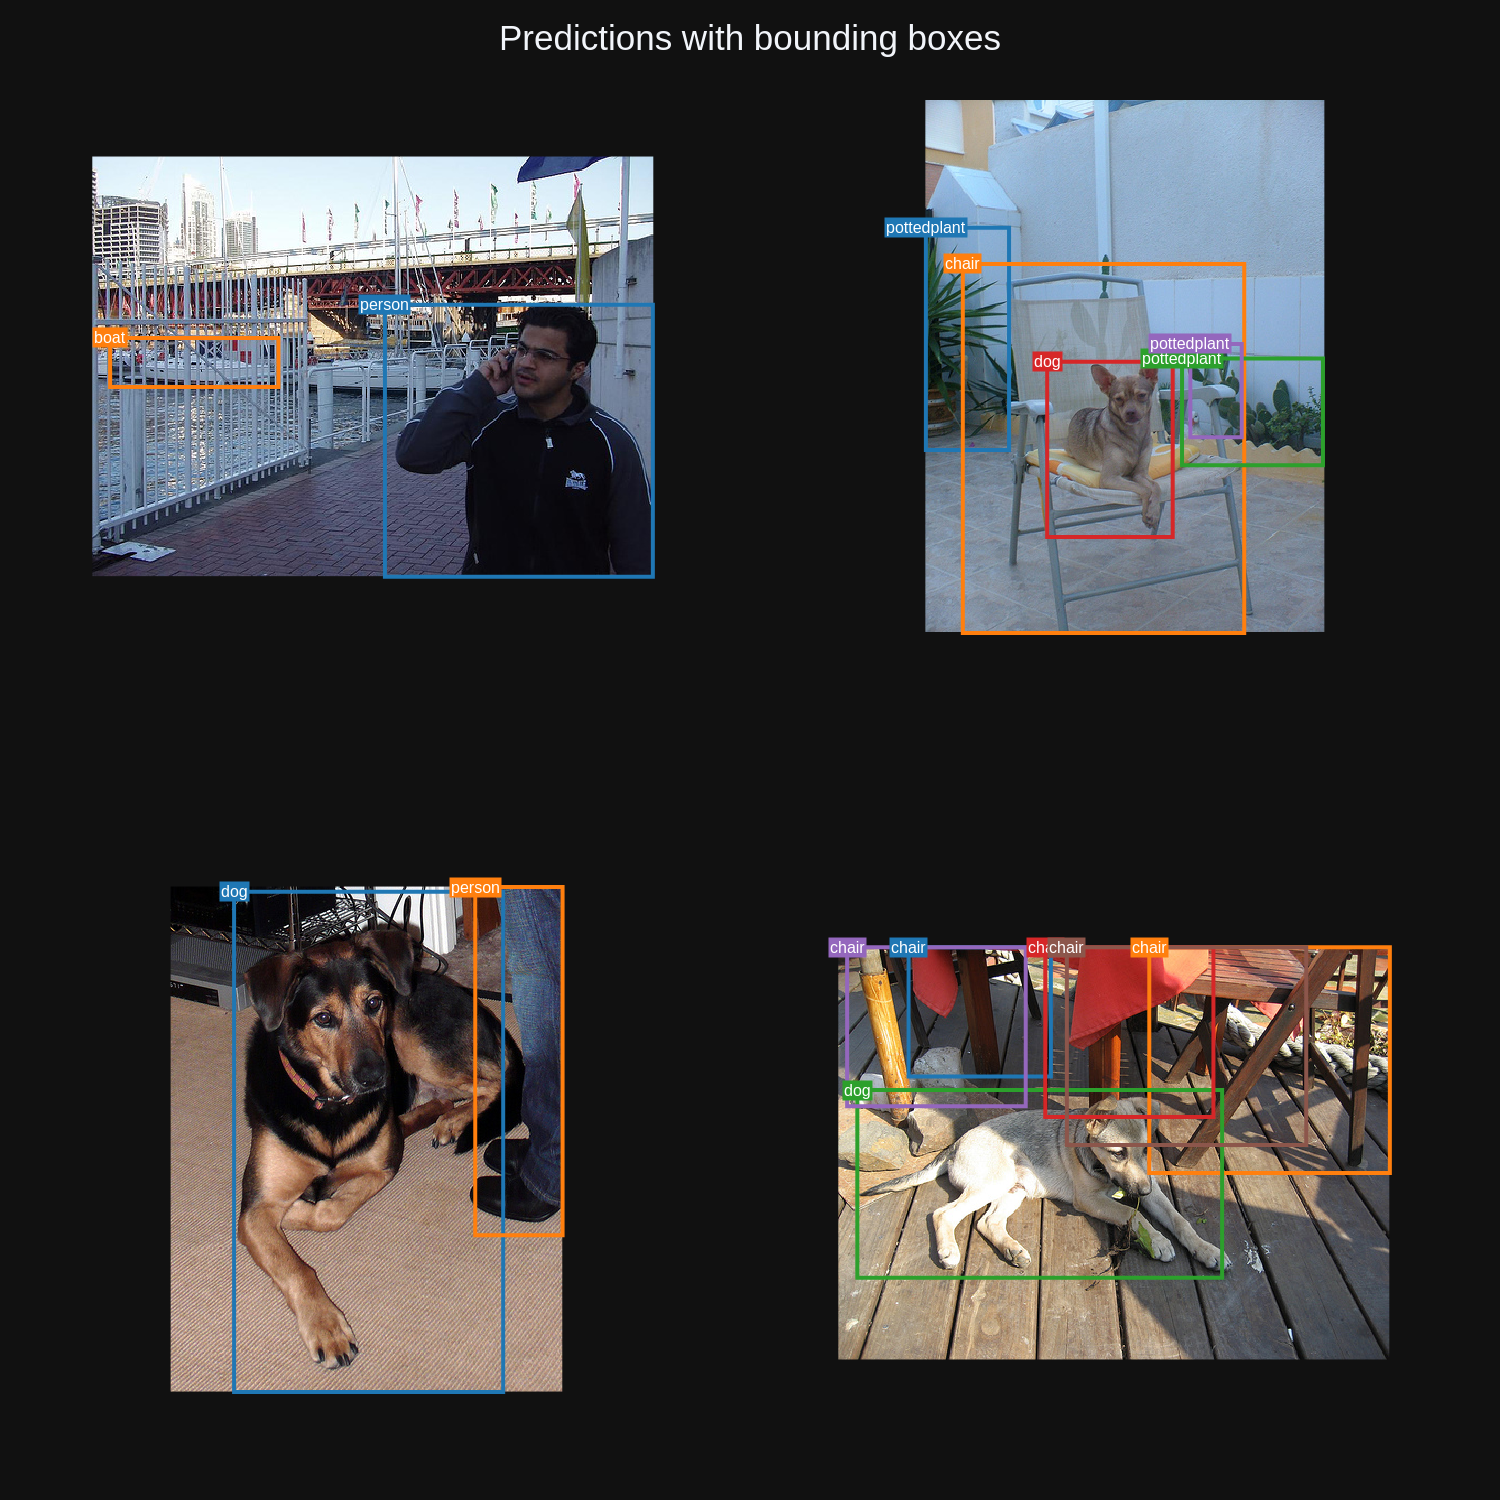

In [101]:
imgs, targets = next(iter(test_loader))
model.eval()
with torch.no_grad():
    outputs_test = model(imgs)
visualize_predictions(imgs, outputs_test)

Посчитаем метрики **IoU** и **mAP** для каждого батча из тестового датасета. 

In [52]:
IoU = IntersectionOverUnion(box_format='xyxy', iou_threshold=0.5)
mAP = MeanAveragePrecision(box_format='xyxy', iou_thresholds=list(np.linspace(0.5, 0.95, 10)), iou_type='bbox')
metrics = dict(iou=[], map_=[], map_50=[], map_75=[])

In [53]:
for img_batch, target_batch in tqdm(test_loader):
    with torch.no_grad():
        outputs = model(img_batch)
    metrics['iou'].append(IoU(outputs, target_batch)['iou'].item())
    mAP_metrics = mAP(outputs, target_batch)
    metrics['map_'].append(mAP_metrics['map'].item())
    metrics['map_50'].append(mAP_metrics['map_50'].item())
    metrics['map_75'].append(mAP_metrics['map_75'].item())

100%|██████████| 1209/1209 [03:53<00:00,  5.18it/s]


In [54]:
mean_iou = np.mean(metrics['iou']).round(3)
mean_map = np.mean(metrics['map_']).round(3)
mean_map_50 = np.mean(metrics['map_50']).round(3)
mean_map_75 = np.mean(metrics['map_75']).round(3)
print(
    f'Mean IoU (threshold 0.5) for test sample: {mean_iou}\n',
    f'Mean global mAP for test sample: {mean_map}\n', 
    f'Mean mAP@50 for test sample: {mean_map_50}\n', 
    f'Mean mAP@75 for test sample: {mean_map_50}', 
    sep=''
)

Mean IoU (threshold 0.5) for test sample: 0.785
Mean global mAP for test sample: 0.454
Mean mAP@50 for test sample: 0.644
Mean mAP@75 for test sample: 0.644


Замерим, сколько времени необходимо сети для обработки одного изображения, чтобы сравнить результаты с *YOLOv8*. Результаты сравнения будут в [<b>readme файле</b>](./README.md)

In [49]:
start_time = time.time()
img = transforms_test(io.read_image('./data/VOC2012/JPEGImages/2007_000027.jpg')).expand(1, -1, -1, -1).to(DEVICE)
with torch.no_grad():
    outputs = model(img)
end_time = time.time()
total_time = end_time - start_time
print(f'{total_time:.5f} seconds')

0.19486 seconds
